Low-Dose CT (ADMM w/ Total Variation)
=====================================

This example demonstrates the use of class [admm.ADMM](../_autosummary/scico.admm.rst#scico.admm.ADMM) to solve a low-dose CT reconstruction problem with anisotropic total variation (TV) regularization.

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x} \|_W^2 + \lambda \| C \mathbf{x} \|_1 \;,$$

where $A$ is the Radon transform, $\mathbf{y}$ is the sinogram, $C$ is a 2D Finite Difference operator, and $\mathbf{x}$ is the desired image.

The weighted norm is an approximation to the Poisson negative log likelihood; see <cite data-cite="sauer-1993-local"/>.

In [1]:
import numpy as np

import jax

from xdesign import Soil, discrete_phantom

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot
from scico.admm import ADMM, LinearSubproblemSolver
from scico.linop.radon import ParallelBeamProjector
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 512  # Phantom size

np.random.seed(0)
x_gt = discrete_phantom(Soil(porosity=0.80), size=384)
x_gt = np.ascontiguousarray(np.pad(x_gt, (64, 64)))
x_gt = np.clip(x_gt, 0, np.inf)  # Clip to positive values
x_gt = jax.device_put(x_gt)  # Convert to jax type, push to GPU

Configure CT projection operator and generate synthetic measurements.

In [3]:
n_projection = 360  # Number of projections
Io = 1e3  # Source flux
alpha = 1e-2  # Attenuation coefficient

angles = np.linspace(0, 2 * np.pi, n_projection)  # Evenly spaced projection angles
A = ParallelBeamProjector(x_gt.shape, 1.0, N, angles)  # Radon transform operator
y_c = A @ x_gt  # Sinogram

Add Poisson noise to projections according to

$$\mathrm{counts} \sim \mathrm{Poi}\left(I_0 exp\left\{- \alpha A \mathbf{x} \right\}\right)$$

$$\mathbf{y} = - \frac{1}{\alpha} \log\left(\mathrm{counts} / I_0\right).$$

We use the NumPy random functionality so we can generate using 64-bit numbers.

In [4]:
counts = np.random.poisson(Io * snp.exp(-alpha * A @ x_gt))
counts = np.clip(counts, a_min=1, a_max=np.inf)  # Replace any 0s count with 1
y = -1 / alpha * np.log(counts / Io)
y = jax.device_put(y)  # Converts back to float32

Setup post processing.
For this example, we clip all reconstructions to the range of the ground truth.

In [5]:
def postprocess(x):
    return snp.clip(x, 0, snp.max(x_gt))

Compute an FBP reconstruction as an initial guess.

In [6]:
x0 = postprocess(A.fbp(y))

Set up and solve the un-weighted reconstruction problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x} \|_2^2 + \lambda \| C \mathbf{x} \|_1.$$

In [7]:
rho = 2.5e3  # ADMM penalty parameter
lambda_unweighted = 2.56e2  # regularization strength
# rho and lambda were selected via a parameter sweep (not shown here)

maxiter = 50  # Number of ADMM iterations
max_inner_iter = 10  # Number of CG iterations per ADMM iteration

f = loss.SquaredL2Loss(y=y, A=A)

admm_unweighted = ADMM(
    f=f,
    g_list=[lambda_unweighted * functional.L1Norm()],
    C_list=[linop.FiniteDifference(x_gt.shape)],
    rho_list=[rho],
    x0=x0,
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"maxiter": max_inner_iter}),
    verbose=True,
)
admm_unweighted.solve()
x_unweighted = postprocess(admm_unweighted.x)

Iter  Objective  Primal Rsdl  Dual Rsdl
---------------------------------------
   0  2.444e+07    6.286e+01  1.298e+02


   1  1.860e+07    1.854e+01  1.149e+02


   2  1.370e+07    2.038e+01  9.751e+01


   3  1.030e+07    1.965e+01  8.038e+01


   4  8.001e+06    1.717e+01  6.543e+01


   5  6.535e+06    1.509e+01  5.167e+01


   6  5.711e+06    1.340e+01  3.821e+01


   7  5.340e+06    1.154e+01  2.529e+01


   8  5.221e+06    9.029e+00  1.477e+01


   9  5.191e+06    6.052e+00  8.553e+00


  10  5.197e+06    4.072e+00  5.078e+00


  11  5.214e+06    2.886e+00  3.460e+00


  12  5.230e+06    2.154e+00  2.808e+00


  13  5.242e+06    1.745e+00  2.451e+00


  14  5.250e+06    1.483e+00  2.178e+00


  15  5.256e+06    1.297e+00  1.943e+00


  16  5.261e+06    1.151e+00  1.739e+00


  17  5.264e+06    1.033e+00  1.554e+00


  18  5.266e+06    9.413e-01  1.395e+00


  19  5.268e+06    8.641e-01  1.257e+00


  20  5.270e+06    7.973e-01  1.141e+00


  21  5.271e+06    7.386e-01  1.044e+00


  22  5.272e+06    6.856e-01  9.621e-01


  23  5.273e+06    6.399e-01  8.909e-01
  24  5.274e+06    6.071e-01  8.290e-01


  25  5.275e+06    5.674e-01  7.787e-01


  26  5.276e+06    5.356e-01  7.266e-01


  27  5.277e+06    5.081e-01  6.780e-01


  28  5.278e+06    4.838e-01  6.320e-01


  29  5.278e+06    4.635e-01  5.893e-01


  30  5.279e+06    4.416e-01  5.536e-01
  31  5.280e+06    4.234e-01  5.213e-01


  32  5.280e+06    4.099e-01  4.900e-01
  33  5.281e+06    3.893e-01  4.657e-01


  34  5.282e+06    3.725e-01  4.459e-01
  35  5.282e+06    3.617e-01  4.179e-01


  36  5.283e+06    3.488e-01  4.063e-01
  37  5.283e+06    3.360e-01  3.890e-01


  38  5.284e+06    3.247e-01  3.694e-01
  39  5.284e+06    3.137e-01  3.515e-01


  40  5.285e+06    3.032e-01  3.352e-01
  41  5.285e+06    2.935e-01  3.199e-01


  42  5.285e+06    2.847e-01  3.050e-01
  43  5.286e+06    2.763e-01  2.921e-01


  44  5.286e+06    2.683e-01  2.799e-01


  45  5.286e+06    2.609e-01  2.683e-01
  46  5.287e+06    2.541e-01  2.565e-01


  47  5.287e+06    2.473e-01  2.459e-01
  48  5.287e+06    2.420e-01  2.374e-01


  49  5.287e+06    2.349e-01  2.263e-01


Set up and solve the weighted reconstruction problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x} \|_W^2 + \lambda \| C \mathbf{x} \|_1 \;,$$

where

  $$W = \mathrm{diag}\left\{\exp( \sqrt{\mathbf{y}}) \right\}.$$

In [8]:
lambda_weighted = 1.14e2

weights = counts / Io  # scale by Io to balance the data vs regularization term
W = linop.Diagonal(snp.sqrt(weights))
f = loss.WeightedSquaredL2Loss(y=y, A=A, weight_op=W)

admm_weighted = ADMM(
    f=f,
    g_list=[lambda_weighted * functional.L1Norm()],
    C_list=[linop.FiniteDifference(x_gt.shape)],
    rho_list=[rho],
    maxiter=maxiter,
    x0=x0,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"maxiter": max_inner_iter}),
    verbose=True,
)
admm_weighted.solve()
x_weighted = postprocess(admm_weighted.x)

Iter  Objective  Primal Rsdl  Dual Rsdl
---------------------------------------
   0  1.290e+07    2.944e+01  5.996e+01


   1  1.143e+07    6.339e+00  5.757e+01


   2  9.900e+06    6.132e+00  5.475e+01


   3  8.509e+06    6.408e+00  5.156e+01


   4  7.269e+06    6.496e+00  4.820e+01


   5  6.181e+06    6.533e+00  4.471e+01


   6  5.242e+06    6.392e+00  4.125e+01


   7  4.438e+06    6.099e+00  3.792e+01


   8  3.756e+06    5.799e+00  3.473e+01


   9  3.181e+06    5.450e+00  3.171e+01


  10  2.701e+06    5.149e+00  2.879e+01


  11  2.306e+06    4.893e+00  2.597e+01


  12  1.985e+06    4.608e+00  2.321e+01


  13  1.734e+06    4.449e+00  2.039e+01


  14  1.545e+06    4.250e+00  1.752e+01


  15  1.410e+06    3.945e+00  1.470e+01


  16  1.321e+06    3.646e+00  1.187e+01


  17  1.268e+06    3.252e+00  9.170e+00


  18  1.239e+06    2.732e+00  6.910e+00


  19  1.225e+06    2.187e+00  5.186e+00


  20  1.219e+06    1.732e+00  3.949e+00


  21  1.216e+06    1.380e+00  3.035e+00


  22  1.216e+06    1.158e+00  2.273e+00


  23  1.216e+06    9.366e-01  1.736e+00


  24  1.217e+06    7.470e-01  1.445e+00


  25  1.217e+06    6.578e-01  1.200e+00


  26  1.218e+06    5.549e-01  1.067e+00


  27  1.218e+06    4.953e-01  9.681e-01


  28  1.219e+06    4.490e-01  8.880e-01


  29  1.219e+06    4.107e-01  8.196e-01


  30  1.219e+06    3.801e-01  7.599e-01


  31  1.219e+06    3.537e-01  7.094e-01


  32  1.219e+06    3.296e-01  6.654e-01


  33  1.219e+06    3.082e-01  6.255e-01


  34  1.219e+06    2.897e-01  5.901e-01


  35  1.219e+06    2.726e-01  5.594e-01


  36  1.219e+06    2.585e-01  5.310e-01


  37  1.220e+06    2.441e-01  5.076e-01


  38  1.220e+06    2.307e-01  4.816e-01
  39  1.220e+06    2.214e-01  4.587e-01


  40  1.220e+06    2.096e-01  4.404e-01
  41  1.220e+06    1.998e-01  4.215e-01


  42  1.220e+06    1.917e-01  4.031e-01
  43  1.220e+06    1.845e-01  3.870e-01


  44  1.220e+06    1.765e-01  3.720e-01


  45  1.220e+06    1.695e-01  3.584e-01
  46  1.220e+06    1.646e-01  3.450e-01


  47  1.220e+06    1.568e-01  3.380e-01
  48  1.220e+06    1.509e-01  3.270e-01


  49  1.220e+06    1.455e-01  3.163e-01


Show recovered images.

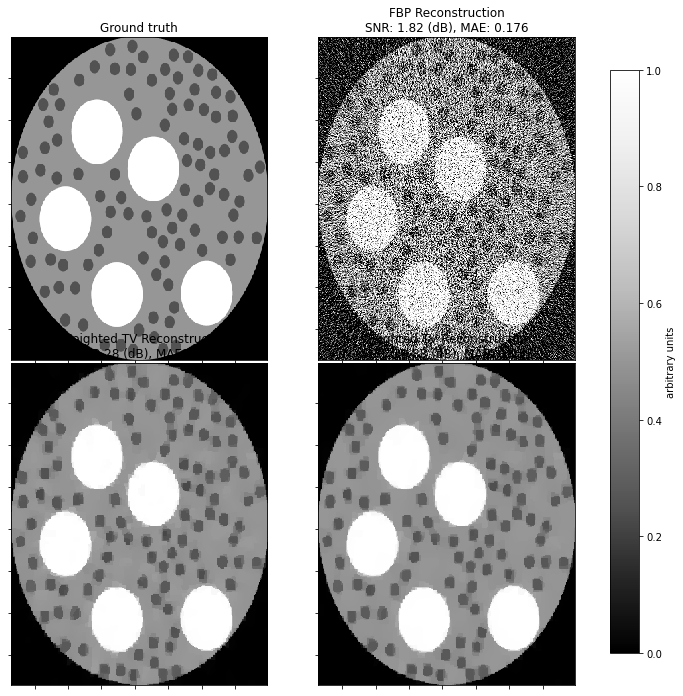

In [9]:
def plot_recon(x, title, ax):
    plot.imview(
        x,
        title=f"{title}\nSNR: {metric.snr(x_gt, x):.2f} (dB), MAE: {metric.mae(x_gt, x):.3f}",
        fig=fig,
        ax=ax,
    )


fig, ax = plot.subplots(nrows=2, ncols=2, figsize=(11, 10))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0, 0])
plot_recon(x0, "FBP Reconstruction", ax=ax[0, 1])
plot_recon(x_unweighted, "Unweighted TV Reconstruction", ax=ax[1, 0])
plot_recon(x_weighted, "Weighted TV Reconstruction", ax=ax[1, 1])
for ax_ in ax.ravel():
    ax_.set_xlim(64, 448)
    ax_.set_ylim(64, 448)
fig.subplots_adjust(left=0.1, right=0.99, top=0.95, bottom=0.05, wspace=0.2, hspace=0.01)
fig.colorbar(
    ax[0, 0].get_images()[0], ax=ax, location="right", shrink=0.9, pad=0.05, label="arbitrary units"
)
fig.show()